# Import des librairies

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os

from IPython.core.pylabtools import figsize
from pandas import Timestamp
from pandas.core.interchange.dataframe_protocol import DataFrame
from polars.datatypes.group import DATETIME_DTYPES

# Extraction du fichier CSV à partir du fichier .zip brut
Le fichier CSV ayant une taille de 383,7 Mo, il est impossible de le stocker sur Github. En effet, Github bloque l'upload des fichiers de plus de 100 Mo. Afin de pouvoir reproduire l'analyse des données et le traitement effectué dans ce Notebook, nous allons donc utiliser le fichier au format .zip tel que récupéré sur Kaggle.
Si une copie locale des données au format CSV existe, alors cette copie est utilisée. Sinon, le fichier CSV est extrait lors de la première exécution du Notebook.

In [45]:
if not os.path.exists("data/raw/btcusd_1-min_data.csv"):
    print("Fichier CSV inexistant, extraction à partir du fichier .zip ...")
    with zipfile.ZipFile("data/raw/btcusd_1-min_data_11_30_2025.zip","r") as zip_ref:
        zip_ref.extractall("data/raw/")
        print("Fichier CSV créé !")
else:
    print("Fichier CSV déjà existant, poursuite de l'exécution ...")


Fichier CSV déjà existant, poursuite de l'exécution ...


# Analyse préliminaire

Chargement des données CSV dans un DataFrame:

In [46]:
df_bitcoin_raw = pd.read_csv("data/raw/btcusd_1-min_data.csv")

In [47]:
df_bitcoin_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7317759 entries, 0 to 7317758
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Timestamp  float64
 1   Open       float64
 2   High       float64
 3   Low        float64
 4   Close      float64
 5   Volume     float64
dtypes: float64(6)
memory usage: 335.0 MB


In [56]:
length_df_raw = len(df_bitcoin_raw)
print(length_df_raw)

7317759


Nous obtenons donc un DataFrame comportant 7 317 759 lignes, avec 6 colonnes qui sont: `Timestamp`, `Open`, `High`, `Low`, `Close` et `Volume`
Toutes ces colonnes sont pour l'instant de `dtypes: float(64)`.

## Statistiques descriptives du DataFrame

In [57]:
df_bitcoin_raw.describe()

,Timestamp,Open,High,Low,Close,Volume
count,7.317759e+06,7.317759e+06,7.317759e+06,7.317759e+06,7.317759e+06,7.317759e+06
mean,1.544948e+09,2.124984e+04,2.125747e+04,2.124200e+04,2.124985e+04,5.128479e+00
std,1.267532e+08,2.992120e+04,2.992935e+04,2.991293e+04,2.992120e+04,2.206739e+01
min,1.325412e+09,3.800000e+00,3.800000e+00,3.800000e+00,3.800000e+00,0.000000e+00
25%,1.435178e+09,4.430000e+02,4.431400e+02,4.428800e+02,4.430000e+02,1.959880e-02
50%,1.544945e+09,7.280770e+03,7.285000e+03,7.276340e+03,7.280650e+03,4.481621e-01
75%,1.654711e+09,3.066300e+04,3.067300e+04,3.065317e+04,3.066301e+04,2.897836e+00
max,1.764547e+09,1.262020e+05,1.262720e+05,1.261580e+05,1.262020e+05,5.853852e+03


In [58]:
df_bitcoin_raw.dtypes

Timestamp    float64
Open         float64
High         float64
Low          float64
Close        float64
Volume       float64
dtype: object

## Identification des valeurs manquantes

In [59]:
print(df_bitcoin_raw.isna().sum())

Timestamp    0
Open         0
High         0
Low          0
Close        0
Volume       0
dtype: int64


On peut observer qu'il n'y a aucune valeurs manquantes.

## Identifications des doublons
Il n'est pas pertinent d'étudier les doublons des colonnes numériques `Open`, `High`, `Low`, `Close` et `Volume`.
En effet, le Bitcoin peut très bien avoir eu le même prix ou volume plusieurs fois depuis que les données ont été collectées.
Nous allons cependant étudier la colonne `Timestamp`, représentant un instant T où les données ont été relevées.

In [60]:
print(df_bitcoin_raw["Timestamp"].iloc[0])


1325412060.0


On remarque que les valeurs contenues dans la colonne `Timestamp` sont au format Timestamp Unix, qui associe un nombre réel au temps mesuré depuis le 1er janvier 1970 à 00:00:00.
Ces valeurs sont donc supposées uniques (un instant T correspondant à un nombre réel unique), nous pouvons donc facilement vérifier l'existance de doublons.

In [64]:
unique_timestamps = df_bitcoin_raw["Timestamp"].nunique()
print(f"Longueur du DataFame et nombre de Timestamp différent équivalent ? {unique_timestamps == length_df_raw}")
print(f"Nombre de lignes doublons: {df_bitcoin_raw.duplicated().sum()}")

Longueur du DataFame et nombre de Timestamp différent équivalent ? True
Nombre de lignes doublons: 0


Le nombre de valeurs uniques de Timestamp étant égal au nombre de lignes dans le DataFrame et n'ayant pas de lignes en double, nous pouvons estimer qu'il n'existe pas de lignes dupliquées dans les données utilisées.

## Conversion de "Timestamp" (float64, unix epoch time) en DateTime
Afin de poursuivre l'analyse sans modifier le DataFrame de base, nous utiliserons désormais une copie.

In [66]:
df_bitcoin_modified = df_bitcoin_raw.copy()

La conversion du Timestamp en format lisible nous permet une meilleure analyse des données. Il est nécessaire de convertire ce Timestamp de `float` à `int`. Ce timestamp correspond au format Unix équivalent aux secondes, ce qui doit être passé en argument.

In [67]:
df_bitcoin_modified["Timestamp"] = pd.to_datetime(df_bitcoin_modified["Timestamp"].astype(int), unit="s")

In [68]:
df_bitcoin_modified

,Timestamp,Open,High,Low,Close,Volume
0,2012-01-01 10:01:00,4.58,4.58,4.58,4.58,0.000000
1,2012-01-01 10:02:00,4.58,4.58,4.58,4.58,0.000000
2,2012-01-01 10:03:00,4.58,4.58,4.58,4.58,0.000000
3,2012-01-01 10:04:00,4.58,4.58,4.58,4.58,0.000000
4,2012-01-01 10:05:00,4.58,4.58,4.58,4.58,0.000000
...,...,...,...,...,...,...
7317754,2025-11-30 23:55:00,90405.00,90452.00,90403.00,90452.00,0.531700
7317755,2025-11-30 23:56:00,90452.00,90481.00,90420.00,90420.00,0.055547
7317756,2025-11-30 23:57:00,90412.00,90458.00,90396.00,90435.00,0.301931
7317757,2025-11-30 23:58:00,90428.00,90428.00,90362.00,90362.00,4.591653


## Analyse de l'existence de périodes manquantes
Les données issues de Timestamp étant désormais dans un format lisible et reconnaissable par Pandas, nous pouvons donc vérifier si des périodes de temps sont manquantes.

Pour cela, nous allons trier les dates dans un ordre ascendant (dans les cas où les lignes ne sont pas correctement "rangées"), puis nous pourrons récupérer les valeurs minimum et maximum afin de créer une `Serie` temporelle équivalente.

En comparant notre colonne `Timestamp` à cette série, nous pourrons identifier les périodes temporelles manquantes si elles existent.

In [69]:
serie_timestamp = df_bitcoin_modified['Timestamp'].sort_values(ascending=True)

In [73]:
first_timestamp = serie_timestamp.iloc[0]
last_timestamp = serie_timestamp.iloc[-1]
print(f"Première valeur Timestamp : {first_timestamp}")
print(f"Dernière valeur Timestamp : {last_timestamp}")

Première valeur Timestamp : 2012-01-01 10:01:00
Dernière valeur Timestamp : 2025-11-30 23:59:00


Créons maintenant la série temporelle permettant de vérifier les différences, en utilisant les valeurs trouvées.

In [83]:
serie_timestamp_difference = pd.Series(pd.date_range(start=first_timestamp, end=last_timestamp, freq='min'))
print(serie_timestamp_difference.head())

0   2012-01-01 10:01:00
1   2012-01-01 10:02:00
2   2012-01-01 10:03:00
3   2012-01-01 10:04:00
4   2012-01-01 10:05:00
dtype: datetime64[ns]


Vérifions désormais la différence.

In [109]:
missing_periods = serie_timestamp_difference[~serie_timestamp_difference.isin(serie_timestamp)]
if len(missing_periods) > 0:
    print(f"Il y a {len(missing_periods)} périodes manquantes au total")

    # Vérifions si ces périodes manquantes sont réunies en un seul 'bloc' ou si elles sont dispersées
    missing_sorted = missing_periods.sort_values(ascending=True) # Tri ascendant pour s'assurer de la cohérence

    # On sait que l'intervalle attendu correspond à 1 minute, puisque notre serie_timestamp_difference a été créé avec une
    # fréquence d'1 minute
    expected_interval = pd.Timedelta(minutes=1)

    # Si la différence est égale à 1 minute, les périodes manquantes sont dans le même 'bloc'
    differences = missing_sorted.diff()

    # On calcule le nombre de 'blocs' où l'intervalle ne correspond pas à la valeur attendue
    num_blocks = (differences != expected_interval).sum()
    print(f"Il y a {num_blocks} blocs de temps manquants")

    # Nous cherchons maintenant à identifier les débuts et fins des blocs de temps manquants
    block_starts = missing_sorted[differences != expected_interval].index
    for i, start_index in enumerate(block_starts):
        # On récupère le timestamp de début du bloc actuel
        start_timestamp = missing_sorted.loc[start_index]

        # On vérifie s'il y a un bloc suivant, `-1` car l'index débute à `0`
        if i < len(block_starts) - 1:
            next_start = block_starts[i + 1]
            # Le timestamp de fin est celui juste avant le début du prochain bloc
            end_index = missing_sorted.index[missing_sorted.index.get_loc(next_start) - 1]
            end_timestamp = missing_sorted.loc[end_index]
        else:
            # Pour le dernier bloc, la fin est la dernière période manquante
            end_timestamp = missing_sorted.iloc[-1]
            print(f"Bloc {i+1}: de {start_timestamp} à {end_timestamp}")
else:
    print("Aucune période manquante détectée")


Il y a 1160 périodes manquantes au total
Il y a 1 blocs de temps manquants
Bloc 1: de 2025-03-15 00:01:00 à 2025-03-15 19:20:00


Nous observons donc un bloc de 1160 minutes consécutives pendant lesquelles les données n'ont pas été relevées.

Cela peut s'expliquer par une panne de la plateforme d'échange de cryptomonnaies utilisée pour collecter les données ou un problème technique rencontré par l'outil utilisé pour collecter les données.

In [113]:
missing_pct = len(missing_periods) / unique_timestamps * 100
print(f"Ces périodes manquantes correspondent à {round(missing_pct, 5)}% des données totales")

Ces périodes manquantes correspondent à 0.01585% des données totales


L'existence de ces périodes manquantes sera importante plus tard, lorsque nous réaliserons des aggrégations temporelles.

In [14]:
df_bitcoin_raw.set_index("Timestamp", inplace=True)

In [ ]:
df = df_bitcoin_raw.copy()
df['returns'] = df['Close'].pct_change()
df['volatility'] = df['returns'].rolling(60).std()
df['price_range'] = df['High'] - df['Low']
df['volume_ma'] = df['Volume'].rolling(60).mean()
df['log_volume'] = np.log(df['Volume'] + 1)

In [15]:
from pandas import DataFrame

In [16]:
def identify_distribution_to_df(df: DataFrame) -> tuple:
    """
    Analyse les colonnes numériques d'un DataFrame et identifie leurs valeurs skew
    et kurt. Retourne les valeurs dans un nouveau DataFrame.\n
    skew: Asymétrie (0 = symétrique)\n
    kurt: Aplatissement (>3 = queues épaisses)
    :param df: DataFrame
    :type df: pandas.DataFrame
    :return: DataFrame contenant les noms des colonnes d'entrée, leurs valeurs
     skew et kurt.
    :rtype: tuple
    """
    distribution_list = []
    for series_name, series in df.select_dtypes(include=np.number).items():
        skew = series.skew()
        kurt = series.kurt()

        column_dict = {"Column": series_name, "skew": skew, "kurt": kurt}
        distribution_list.append(column_dict)

    df_stats = pd.DataFrame(distribution_list)

    return df_stats


In [17]:
df_bitcoin_stats = identify_distribution_to_df(df_bitcoin_raw)

In [18]:
df_bitcoin_stats

,Column,skew,kurt
0,Open,1.654101,1.891232
1,High,1.653784,1.889910
2,Low,1.654428,1.892597
3,Close,1.654093,1.891205
4,Volume,27.799998,2479.572929


## Calcul des Z-Scores

In [19]:
def calculate_z_scores(df: DataFrame)-> DataFrame:
    z_score_list = []

    for series_name, series in df.select_dtypes(include=np.number).items():
        z_scores = (df[series_name] - df[series_name].mean()) / df[series_name].std()
        z_score_list.append(z_scores)

    return pd.DataFrame(z_score_list)



On transpose le DataFrame afin de conserver les mêmes colonnes

In [20]:
df_z_score = calculate_z_scores(df_bitcoin_raw).T

In [21]:
df_z_score = df_z_score[df_z_score.gt(3).any(axis=1)]

In [22]:
print(df_z_score)

                         Open      High       Low     Close    Volume
Timestamp                                                            
2012-02-23 14:48:00 -0.710034 -0.710096 -0.709969 -0.710035  3.966323
2012-02-24 03:09:00 -0.710026 -0.710088 -0.709961 -0.710027  3.392858
2012-03-08 21:46:00 -0.710026 -0.710088 -0.709961 -0.710027  3.911397
2012-03-09 15:45:00 -0.710026 -0.710087 -0.709960 -0.710026  4.334996
2012-03-13 17:02:00 -0.710025 -0.710086 -0.709961 -0.710027  3.995558
...                       ...       ...       ...       ...       ...
2025-11-21 15:13:00  2.105803  2.105643  2.097488  2.100055  3.877852
2025-11-21 18:05:00  2.102494  2.104106  2.096819  2.096011  3.118334
2025-11-21 18:48:00  2.113824  2.128096  2.113835  2.125354  4.109853
2025-11-21 20:29:00  2.082876  2.082054  2.080037  2.079233  3.026075
2025-11-21 21:22:00  2.119406  2.121547  2.120254  2.121979  3.212936

[215636 rows x 5 columns]


In [23]:
def identify_quartiles(df: DataFrame) -> DataFrame:
    quartiles_list = []
    for series_name, series in df.select_dtypes(include=np.number).items():
        q1 = series.quantile(0.25)
        q3 = series.quantile(0.75)
        iqr = q3 - q1
        lower_fence = q1 - 1.5 * iqr
        upper_fence = q3 + 1.5 * iqr

        column_dict = {"Column": series_name, "Q1": q1, "Q3": q3, "IQR": iqr, "Lower Fence": lower_fence, "Upper Fence": upper_fence}
        quartiles_list.append(column_dict)

    df_quartiles = pd.DataFrame(quartiles_list)

    return df_quartiles

In [24]:
identify_quartiles(df_bitcoin_raw)

,Column,Q1,Q3,IQR,Lower Fence,Upper Fence
0,Open,443.000000,30663.000000,30220.000000,-44887.000000,75993.000000
1,High,443.140000,30673.000000,30229.860000,-44901.650000,76017.790000
2,Low,442.880000,30653.165000,30210.285000,-44872.547500,75968.592500
3,Close,443.000000,30663.015000,30220.015000,-44887.022500,75993.037500
4,Volume,0.019599,2.897836,2.878237,-4.297757,7.215192


# Aggrégations temporelles

In [25]:
df_bitcoin_1_hour = df_bitcoin_raw.resample('h').agg({
    'Open': ['mean', 'min', 'max', 'std'],
    'High': ['mean', 'min', 'max', 'std'],
    'Low': ['mean', 'min', 'max', 'std'],
    'Close': ['mean', 'min', 'max', 'std'],
    'Volume': ['mean', 'sum', 'min', 'max', 'std']
})

df_bitcoin_1_day = df_bitcoin_raw.resample('d').agg({
    'Open': ['mean', 'min', 'max', 'std'],
    'High': ['mean', 'min', 'max', 'std'],
    'Low': ['mean', 'min', 'max', 'std'],
    'Close': ['mean', 'min', 'max', 'std'],
    'Volume': ['mean', 'sum', 'min', 'max', 'std']
})

df_bitcoin_1_month = df_bitcoin_raw.resample('ME').agg({
    'Open': ['mean', 'min', 'max', 'std'],
    'High': ['mean', 'min', 'max', 'std'],
    'Low': ['mean', 'min', 'max', 'std'],
    'Close': ['mean', 'min', 'max', 'std'],
    'Volume': ['mean', 'sum', 'min', 'max', 'std']
})

In [26]:
df_bitcoin_1_hour

Open                                  \
                             mean       min       max         std   
Timestamp                                                           
2012-01-01 10:00:00      4.580000      4.58      4.58    0.000000   
2012-01-01 11:00:00      4.580000      4.58      4.58    0.000000   
2012-01-01 12:00:00      4.580000      4.58      4.58    0.000000   
2012-01-01 13:00:00      4.580000      4.58      4.58    0.000000   
2012-01-01 14:00:00      4.580000      4.58      4.58    0.000000   
...                           ...       ...       ...         ...   
2025-11-30 19:00:00  91425.850000  91312.00  91486.00   50.663337   
2025-11-30 20:00:00  91384.250000  91216.00  91605.00  114.462432   
2025-11-30 21:00:00  91142.233333  90946.00  91339.00   97.221461   
2025-11-30 22:00:00  91198.983333  91060.00  91332.00   74.497069   
2025-11-30 23:00:00  90763.866667  90363.00  91240.00  220.672583   

                             High                                  \
                             mean       min       max         std   
Timestamp                                                           
2012-01-01 10:00:00      4.580000      4.58      4.58    0.000000   
2012-01-01 11:00:00      4.580000      4.58      4.58    0.000000   
2012-01-01 12:00:00      4.580000      4.58      4.58    0.000000   
2012-01-01 13:00:00      4.580000      4.58      4.58    0.000000   
2012-01-01 14:00:00      4.580000      4.58      4.58    0.000000   
...                           ...       ...       ...         ...   
2025-11-30 19:00:00  91435.283333  91328.00  91486.00   47.219319   
2025-11-30 20:00:00  91394.750000  91220.00  91618.00  113.990429   
2025-11-30 21:00:00  91157.750000  90976.00  91340.00   92.740320   
2025-11-30 22:00:00  91214.883333  91077.00  91332.00   72.208054   
2025-11-30 23:00:00  90786.416667  90386.00  91253.00  217.593564   

                              Low            ...                     Close  \
                             mean       min  ...         std          mean   
Timestamp                                    ...                             
2012-01-01 10:00:00      4.580000      4.58  ...    0.000000      4.580000   
2012-01-01 11:00:00      4.580000      4.58  ...    0.000000      4.580000   
2012-01-01 12:00:00      4.580000      4.58  ...    0.000000      4.580000   
2012-01-01 13:00:00      4.580000      4.58  ...    0.000000      4.580000   
2012-01-01 14:00:00      4.580000      4.58  ...    0.000000      4.580000   
...                           ...       ...  ...         ...           ...   
2025-11-30 19:00:00  91418.450000  91312.00  ...   51.145000  91428.550000   
2025-11-30 20:00:00  91373.383333  91191.00  ...  115.184170  91384.116667   
2025-11-30 21:00:00  91124.666667  90918.00  ...  100.573047  91140.566667   
2025-11-30 22:00:00  91188.600000  91060.00  ...   75.591722  91203.233333   
2025-11-30 23:00:00  90730.033333  90362.00  ...  218.871835  90752.883333   

                                                       Volume             \
                          min       max         std      mean        sum   
Timestamp                                                                  
2012-01-01 10:00:00      4.58      4.58    0.000000  0.000000   0.000000   
2012-01-01 11:00:00      4.58      4.58    0.000000  0.000000   0.000000   
2012-01-01 12:00:00      4.58      4.58    0.000000  0.000000   0.000000   
2012-01-01 13:00:00      4.58      4.58    0.000000  0.000000   0.000000   
2012-01-01 14:00:00      4.58      4.58    0.000000  0.000000   0.000000   
...                       ...       ...         ...       ...        ...   
2025-11-30 19:00:00  91317.00  91486.00   48.771840  0.302038  18.122278   
2025-11-30 20:00:00  91216.00  91608.00  115.060499  0.727152  43.629128   
2025-11-30 21:00:00  90938.00  91340.00   95.167714  1.011637  60.698210   
2025-11-30 22:00:00  91060.00  91332.00   74.980080  0.674728  40.483658   
2025-11-30 23:

In [27]:
df_bitcoin_1_day

Open                                           High  \
                    mean       min       max          std          mean   
Timestamp                                                                 
2012-01-01      4.645697      4.58      4.84     0.113050      4.645697   
2012-01-02      4.975000      4.84      5.00     0.058115      4.975000   
2012-01-03      5.085500      5.00      5.32     0.133027      5.085500   
2012-01-04      5.170250      4.93      5.57     0.191264      5.170396   
2012-01-05      5.954292      5.57      6.46     0.359888      5.954361   
...                  ...       ...       ...          ...           ...   
2025-11-26  88055.800000  86312.00  90574.00  1271.175142  88084.990278   
2025-11-27  91244.102778  90126.00  91888.00   349.019497  91266.106944   
2025-11-28  91323.566667  90255.00  92970.00   456.987685  91347.988889   
2025-11-29  90745.786111  90265.00  91158.00   162.063175  90757.859722   
2025-11-30  91187.037500  90363.00  91940.00   295.043465  91200.045833   

                                                      Low            ...  \
                 min       max          std          mean       min  ...   
Timestamp                                                            ...   
2012-01-01      4.58      4.84     0.113050      4.645697      4.58  ...   
2012-01-02      4.84      5.00     0.058115      4.975000      4.84  ...   
2012-01-03      5.00      5.32     0.133027      5.085500      5.00  ...   
2012-01-04      4.93      5.57     0.191489      5.170250      4.93  ...   
2012-01-05      5.57      6.46     0.359905      5.954292      5.57  ...   
...              ...       ...          ...           ...       ...  ...   
2025-11-26  86429.00  90646.00  1274.741147  88029.613194  86304.00  ...   
2025-11-27  90155.00  91926.00   345.026870  91224.078472  90091.00  ...   
2025-11-28  90294.00  93091.00   461.139705  91300.628472  90233.00  ...   
2025-11-29  90298.00  91179.00   160.707197  90735.099306  90216.00  ...   
2025-11-30  90386.00  91969.00   296.797981  91174.666667  90362.00  ...   

                                Close                                   \
                    std          mean       min       max          std   
Timestamp                                                                
2012-01-01     0.113050      4.645697      4.58      4.84     0.113050   
2012-01-02     0.058115      4.975000      4.84      5.00     0.058115   
2012-01-03     0.133027      5.085500      5.00      5.32     0.133027   
2012-01-04     0.191264      5.170396      4.93      5.57     0.191489   
2012-01-05     0.359888      5.954361      5.57      6.46     0.359905   
...                 ...           ...       ...       ...          ...   
2025-11-26  1268.436154  88059.012500  86323.00  90574.00  1272.385073   
2025-11-27   351.515136  91244.900000  90126.00  91925.00   348.197912   
2025-11-28   451.253723  91324.902778  90283.00  92966.00   456.817739   
2025-11-29   163.591019  90747.095833  90279.00  91179.00   162.122203   
2025-11-30   294.129497  91187.949306  90362.00  91940.00   295.991712   

              Volume                                              
                mean          sum       min        max       std  
Timestamp                                                         
2012-01-01  0.011919    10.000000  0.000000  10.000000  0.345238  
2012-01-02  0.007014    10.100000  0.000000  10.100000  0.266158  
2012-01-03  0.074365   107.085281  0.000000  29.319392  1.276256  
2012-01-04  0.074468   107.233260  0.000000  43.312196  1.347052  
2012-01-05  0.048839    70.328742  0.000000  16.000000  0.757699  
...              ...          ...       ...        ...       ...  
2025-11-26  2.063223  2971.040931  0.001277  38.828305  3.512306  
2025-11-27  1.325523  1908.753444  0.000000  64.225712  3.320660  
2025-11-28  1.601382  2305.990380  0.000226  47.646763  3.586475  
2025-11-29  0.473333   681.599464  0.000000  31.861756  1.71665

In [28]:
df_bitcoin_1_month

Open                                              High  \
                     mean        min        max          std           mean   
Timestamp                                                                     
2012-01-31       6.253758       3.80       7.38     0.705640       6.253799   
2012-02-29       5.234570       3.80       6.50     0.595463       5.234590   
2012-03-31       4.954475       4.54       5.44     0.221076       4.954491   
2012-04-30       4.980317       4.69       5.43     0.141783       4.980339   
2012-05-31       5.041776       4.86       5.15     0.061260       5.041785   
...                   ...        ...        ...          ...            ...   
2025-07-31  115184.770632  105161.00  123110.00  4612.148773  115204.345430   
2025-08-31  114928.012321  107472.00  124479.00  3349.460342  114950.159498   
2025-09-30  113013.529792  107284.00  117937.00  2526.187723  113030.848079   
2025-10-31  114289.591935  103642.00  126202.00  5562.454638  114320.965143   
2025-11-30   96533.329097   80634.00  111129.00  7802.752852   96567.225394   

                                                         Low             ...  \
                  min        max          std           mean        min  ...   
Timestamp                                                                ...   
2012-01-31       3.80       7.38     0.705650       6.253711       3.80  ...   
2012-02-29       3.80       6.50     0.595471       5.234526       3.80  ...   
2012-03-31       4.54       5.44     0.221081       4.954437       4.54  ...   
2012-04-30       4.69       5.43     0.141790       4.980292       4.69  ...   
2012-05-31       4.86       5.15     0.061264       5.041760       4.86  ...   
...               ...        ...          ...            ...        ...  ...   
2025-07-31  105212.00  123236.00  4616.464131  115164.996729  105130.00  ...   
2025-08-31  107540.00  124517.00  3349.944905  114906.082908  107389.00  ...   
2025-09-30  107290.00  117968.00  2524.220176  112996.953264  107270.00  ...   
2025-10-31  103844.00  126272.00  5558.629492  114257.687612  103530.00  ...   
2025-11-30   80844.00  111129.00  7799.827186   96499.454861   80537.00  ...   

                                 Close                                     \
                    std           mean        min        max          std   
Timestamp                                                                   
2012-01-31     0.705625       6.253767       3.80       7.38     0.705631   
2012-02-29     0.595477       5.234547       3.80       6.50     0.595484   
2012-03-31     0.221081       4.954453       4.54       5.44     0.221086   
2012-04-30     0.141786       4.980315       4.69       5.43     0.141792   
2012-05-31     0.061267       5.041769       4.86       5.15     0.061270   
...                 ...            ...        ...        ...          ...   
2025-07-31  4607.615515  115184.855197  105161.00  123236.00  4612.206637   
2025-08-31  3348.978653  114928.323746  107471.00  124482.00  3349.888990   
2025-09-30  2528.417164  113013.985926  107285.00  117937.00  2526.363138   
2025-10-31  5566.090501  114289.491801  103634.00  126202.00  5562.384398   
2025-11-30  7805.630477   96533.232199   80638.00  111129.00  7802.615576   

              Volume                                           
                mean           sum  min         max       std  
Timestamp                                                      
2012-01-31  0.045693   2012.253436  0.0   43.312196  0.835500  
2012-02-29  0.114023   4761.609081  0.0   92.654874  1.697509  
2012-03-31  0.202725   9049.626282  0.0  247.560124  3.516429  
2012-04-30  0.381578  16484.167772  0.0  300.516098  5.603393  
2012-05-31  0.414877  18520.103801  0.0  384.988000  5.742782  
...              ...           ...  ...         ...       ...  
2025-07-31  0.929587  41496.747723  0.0  122.751398  3.110638  
2025-08-31  1.076421  48051.453156  0.0   59.470426  2.411568  
2025-09-30

# Analyse des tendances et volatilité
## Visualisation de l’évolution du prix dans le temps (courbe Close).

In [29]:
print(df_bitcoin_1_hour.columns)

MultiIndex([(  'Open', 'mean'),
            (  'Open',  'min'),
            (  'Open',  'max'),
            (  'Open',  'std'),
            (  'High', 'mean'),
            (  'High',  'min'),
            (  'High',  'max'),
            (  'High',  'std'),
            (   'Low', 'mean'),
            (   'Low',  'min'),
            (   'Low',  'max'),
            (   'Low',  'std'),
            ( 'Close', 'mean'),
            ( 'Close',  'min'),
            ( 'Close',  'max'),
            ( 'Close',  'std'),
            ('Volume', 'mean'),
            ('Volume',  'sum'),
            ('Volume',  'min'),
            ('Volume',  'max'),
            ('Volume',  'std')],
           )


<Axes: xlabel='Timestamp'>

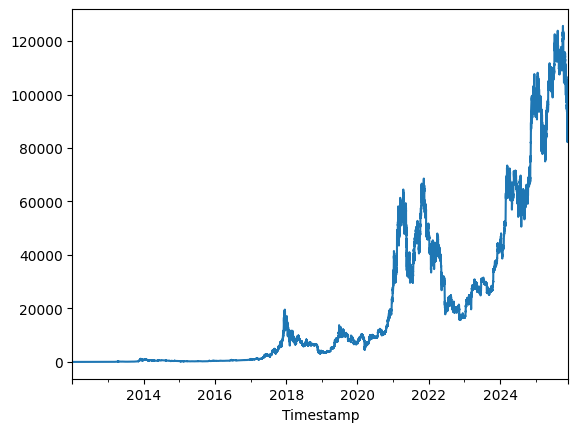

In [30]:
df_bitcoin_1_hour[('Close', 'mean')].plot()

# Identification des périodes de Bull Run et de Crash

In [31]:
class BitcoinTrendDetector:
    """
    Analyse les données de prix du Bitcoin pour identifier les tendances du marché, telles que les crashs 
    et les bull runs, en fonction de seuils et de durées prédéfinis.

    :ivar df: DataFrame contenant le jeu de données de prix du Bitcoin
    :type df: pandas.DataFrame
    :ivar price_col: Series contenant la colonne de prix du DataFrame
    :type price_col: pandas.Series
    :ivar regimes: DataFrame résumant les périodes de tendance identifiées, incluant les dates de début et de fin, 
        la durée et le rendement
    :type regimes: pandas.DataFrame
    """

    def __init__(self, df, price_col):
        """
        Initialise l'objet
        
        :param df: DataFrame contenant les données de prix du Bitcoin
        :type df: pandas.DataFrame
        :param price_col: Colonne les prix à analyser
        :type price_col: pandas.Series
        """
        self.df = df.copy()
        self.price_col = price_col
        self.regimes = None

    def identify_trends(
            self,
            min_crash_timeframe: str,
            min_bullrun_timeframe: str,
            crash_threshold: float,
            bullrun_threshold: float,
            window: str):
        """
        Identifie les tendances du marché (crash, bullrun, neutral) en fonction de seuils et durées spécifiés.
        
        :param min_crash_timeframe: Durée minimale pour qu'un crash soit considéré valide ('7D' pour 7 jours)
        :type min_crash_timeframe: str
        :param min_bullrun_timeframe: Durée minimale pour qu'un bull run soit considéré valide ('30D' pour 30 jours)
        :type min_bullrun_timeframe: str
        :param crash_threshold: Seuil de perte pour identifier un crash (-0.30 pour -30%)
        :type crash_threshold: float
        :param bullrun_threshold: Seuil de gain depuis le plus bas pour identifier un bull run (1.0 pour +100%)
        :type bullrun_threshold: float
        :param window: Fenêtre pour calculer les maximums et minimums roulants ('180D' pour 180 jours)
        :type window: str
        :return: DataFrame contenant les périodes de tendance identifiées avec leurs caractéristiques
        :rtype: pandas.DataFrame
        """
        df = self.df.copy()
        price_col = self.price_col.copy()

        # Trouve le maximum local sur la periode etudiee
        rolling_max = price_col.rolling(window=window, min_periods=1).max()
        # Calcule le drawdown (perte) depuis le maximum local
        drawdown = (price_col - rolling_max) / rolling_max

        # Trouve le minimum local sur la periode etudiee
        rolling_min = price_col.rolling(window=window, min_periods=1).min()
        # Calcule le gain depuis le minimum local
        gain_from_low = (price_col - rolling_min) / rolling_min

        # Nouvelle serie initialisee en trend 'neutral'
        trend = pd.Series('neutral', index=df.index)

        # On identifie les periodes de perte superieures a notre seuil => crash
        crash_mask = drawdown <= crash_threshold
        trend[crash_mask] = 'crash'

        # On identifie les periodes de gain superieures a notre seuil => bull run
        bull_mask = gain_from_low >= bullrun_threshold
        trend[bull_mask] = 'bullrun'

        # Applique le filtre de durée minimale pour les crashs et bull runs
        trend = self._apply_duration_filter(trend, 'crash', min_crash_timeframe)
        trend = self._apply_duration_filter(trend, 'bullrun', min_bullrun_timeframe)

        # Ajoute les colonnes de tendance et métriques au DataFrame
        df['trend'] = trend
        df['drawdown'] = drawdown
        df['gain_from_low'] = gain_from_low

        self.df = df
        self.regimes = self._extract_trend_periods()

        return self.regimes

    @staticmethod
    def _apply_duration_filter(trend_series, trend_type, min_duration):
        """
        Filtre les périodes de tendance en fonction d'une durée minimale.
        
        :param trend_series: Série contenant les tendances identifiées
        :type trend_series: pandas.Series
        :param trend_type: Type de tendance à filtrer ('crash' ou 'bullrun')
        :type trend_type: str
        :param min_duration: Durée minimale requise ('7D')
        :type min_duration: str
        :return: Série de tendances filtrée
        :rtype: pandas.Series
        """
        result = trend_series.copy()
        min_delta = pd.Timedelta(min_duration)

        # Identifie les périodes correspondant au type de tendance spécifié
        is_trend = trend_series == trend_type
        trend_changes = is_trend.astype(int).diff().fillna(0)

        # Trouve les points de début et de fin de chaque période
        starts = trend_series.index[trend_changes == 1]
        ends = trend_series.index[trend_changes == -1]

        # Vérifie la durée de chaque période et filtre celles trop courtes
        for start, end in zip(starts, ends):
            duration = end - start
            if duration < min_delta:
                result.loc[start:end] = 'neutral'

        return result

    def _extract_trend_periods(self):
        """
        Extrait les périodes de tendance du DataFrame.

        :return: DataFrame contenant les informations sur chaque période de tendance (type, dates, durée, 
                 prix de début/fin, rendement)
        :rtype: pandas.DataFrame
        """
        trend = self.df['trend']
        trend_changes = (trend != trend.shift()).astype(int)
        price_col = self.price_col.copy()

        periods = []
        current_trend = trend.iloc[0]
        start_date = trend.index[0]

        # Parcourt toutes les données pour identifier les changements de tendance
        for i in range(1, len(trend)):
            if trend_changes.iloc[i]:
                # Si la tendance précédente n'était pas neutre, on l'enregistre
                if current_trend != 'neutral':
                    periods.append({
                        'trend': current_trend,
                        'start': start_date,
                        'end': trend.index[i - 1],
                        'duration': trend.index[i - 1] - start_date,
                        'start_price': price_col.loc[start_date],
                        'end_price': price_col.loc[trend.index[i - 1]]
                    })
                current_trend = trend.iloc[i]
                start_date = trend.index[i]

        # Traite la dernière période si elle n'est pas neutre
        if current_trend != 'neutral':
            periods.append({
                'trend': current_trend,
                'start': start_date,
                'end': trend.index[-1],
                'duration': trend.index[-1] - start_date,
                'start_price': price_col.loc[start_date],
                'end_price': price_col.iloc[-1]
            })

        periods_df = pd.DataFrame(periods)
        # Calcule le rendement en pourcentage pour chaque période
        if len(periods_df) > 0:
            periods_df['return'] = (periods_df['end_price'] / periods_df['start_price'] - 1) * 100

        return periods_df


In [32]:
detector = BitcoinTrendDetector(df_bitcoin_1_day, price_col=df_bitcoin_1_day[('Close', 'mean')])
regimes = detector.identify_trends(
    min_crash_timeframe='30D',
    min_bullrun_timeframe='30D',
    crash_threshold=-0.30,
    bullrun_threshold=1.0,
    window='180D'
)

In [33]:
regimes

,trend,start,end,duration,start_price,end_price,return
0,bullrun,2012-07-27,2013-01-01,158 days,8.795403,13.201264,50.092773
1,bullrun,2013-01-29,2013-09-15,229 days,18.918569,124.569257,558.449664
2,bullrun,2013-10-14,2014-05-02,200 days,134.694646,453.264708,236.512788
3,crash,2014-05-03,2014-06-05,33 days,444.348931,650.763632,46.453291
4,crash,2014-09-17,2015-06-14,270 days,459.228139,232.183104,-49.440575
5,bullrun,2017-05-02,2018-03-26,328 days,1428.131056,8295.539076,480.866794
6,crash,2018-03-27,2018-07-24,119 days,7980.836069,7979.561639,-0.015969
7,crash,2018-07-31,2018-09-02,33 days,7987.310535,7225.186361,-9.541687
8,crash,2018-09-06,2018-11-05,60 days,6497.498375,6410.237799,-1.342987
9,crash,2018-11-15,2019-04-02,138 days,5497.084139,4531.583514,-17.563868


Maintenant que nous avons identifier nos périodes de Bull run et de Crash, nous pouvons les tracer (avec une échelle de prix logarithmique pour une meilleure clartée)

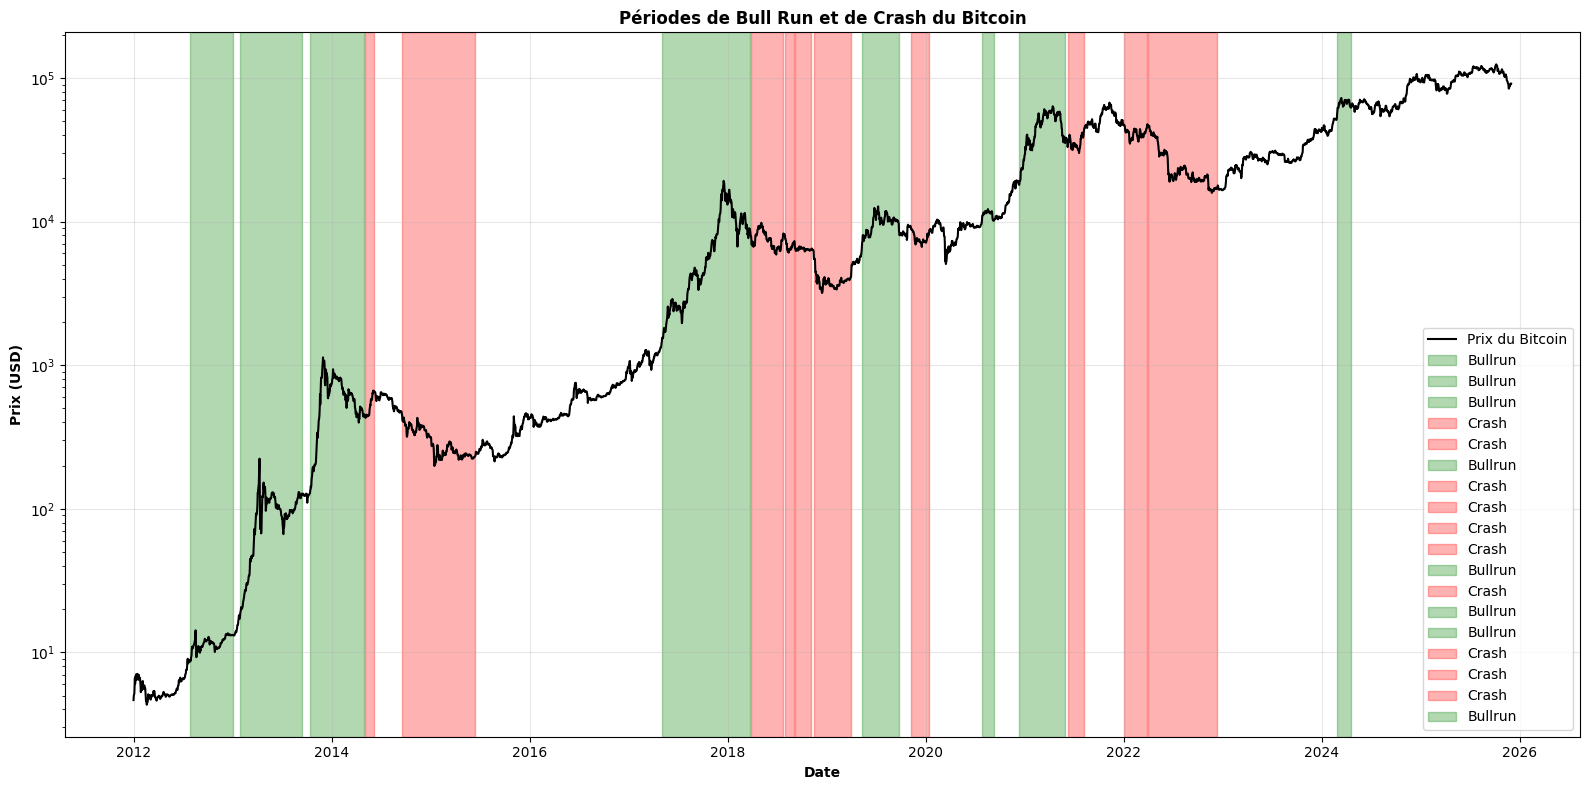

In [34]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(detector.df.index, detector.price_col, color='black', linewidth=1.5, label='Prix du Bitcoin')

for _, period in detector.regimes.iterrows():
    if period['trend'] == 'bullrun':
        ax.axvspan(period['start'], period['end'], alpha=0.3, color='green', label='Bullrun')
    elif period['trend'] == 'crash':
        ax.axvspan(period['start'], period['end'], alpha=0.3, color='red', label='Crash')

ax.set_yscale('log')
ax.set_xlabel('Date', fontweight='bold')
ax.set_ylabel('Prix (USD)', fontweight='bold')
ax.set_title('Périodes de Bull Run et de Crash du Bitcoin', fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

# Analyse de la volatilité et variation relative
Nous allons analyser la volatilité pour les aggrégations temporelles `df_bitcoin_1_day` et `df_bitcoin_1_hour`
Calcul de la volatilé en utilisant un écart-type glissant (sur 24h et 30 jours respectivement)

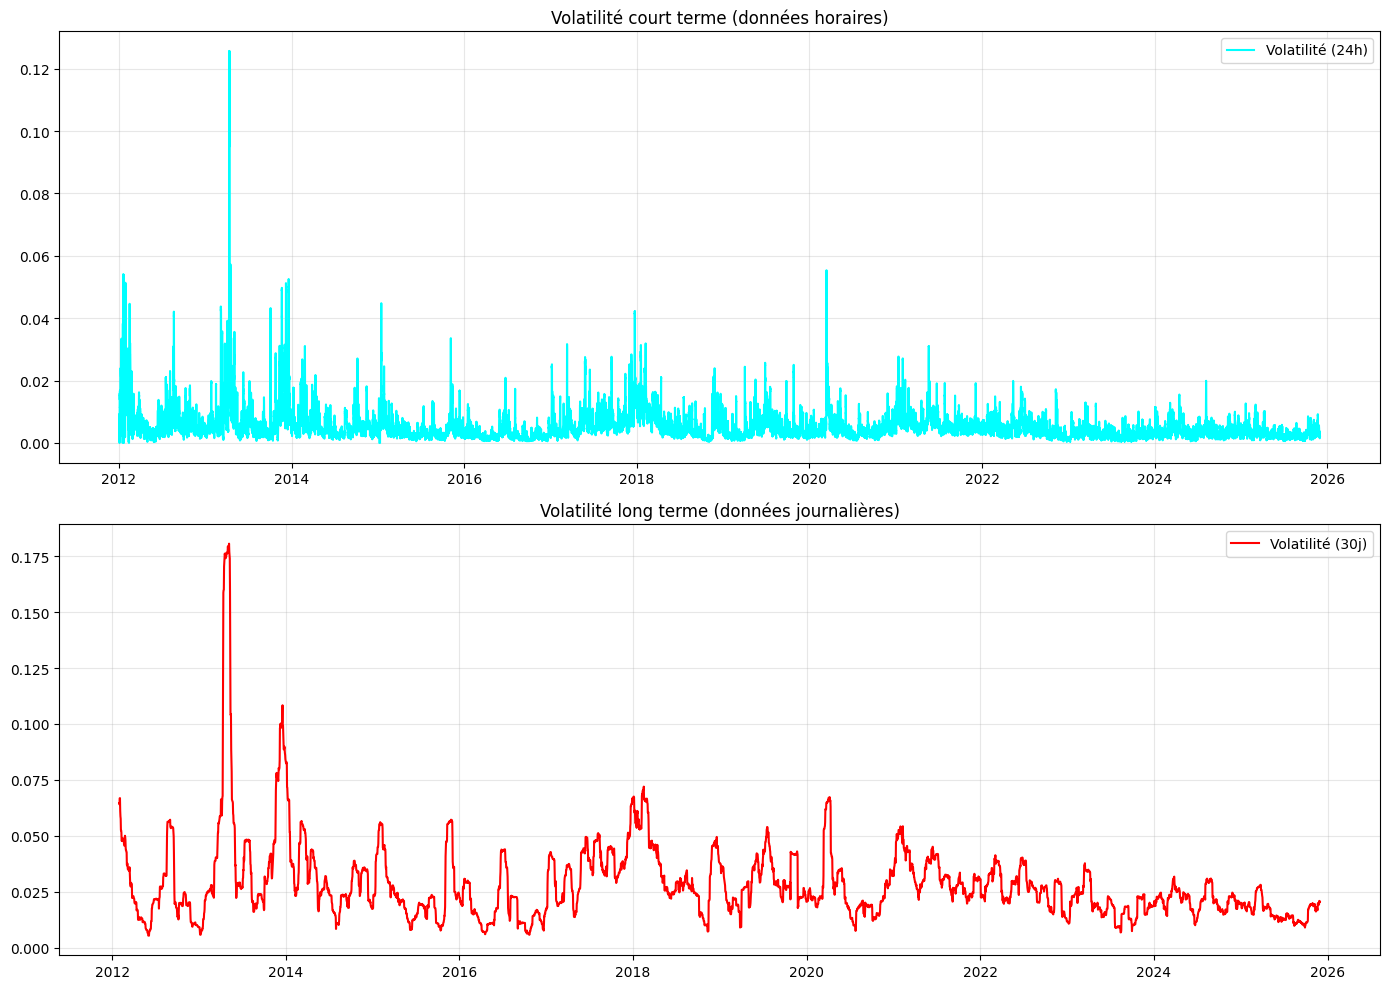

In [35]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

df_bitcoin_1_hour['returns'] = df_bitcoin_1_hour[('Close', 'mean')].pct_change(fill_method=None)
df_bitcoin_1_hour['volatility_24h'] = df_bitcoin_1_hour['returns'].rolling(window=24).std()
ax1.plot(df_bitcoin_1_hour.index, df_bitcoin_1_hour['volatility_24h'],color='cyan', label='Volatilité (24h)')
ax1.set_title('Volatilité court terme (données horaires)')
ax1.legend()
ax1.grid(True, alpha=0.3)

df_bitcoin_1_day['returns'] = df_bitcoin_1_day[('Close', 'mean')].pct_change(fill_method=None)
df_bitcoin_1_day['volatility_30d'] = df_bitcoin_1_day['returns'].rolling(window=30).std()
ax2.plot(df_bitcoin_1_day.index, df_bitcoin_1_day['volatility_30d'], color='red', label='Volatilité (30j)')
ax2.set_title('Volatilité long terme (données journalières)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

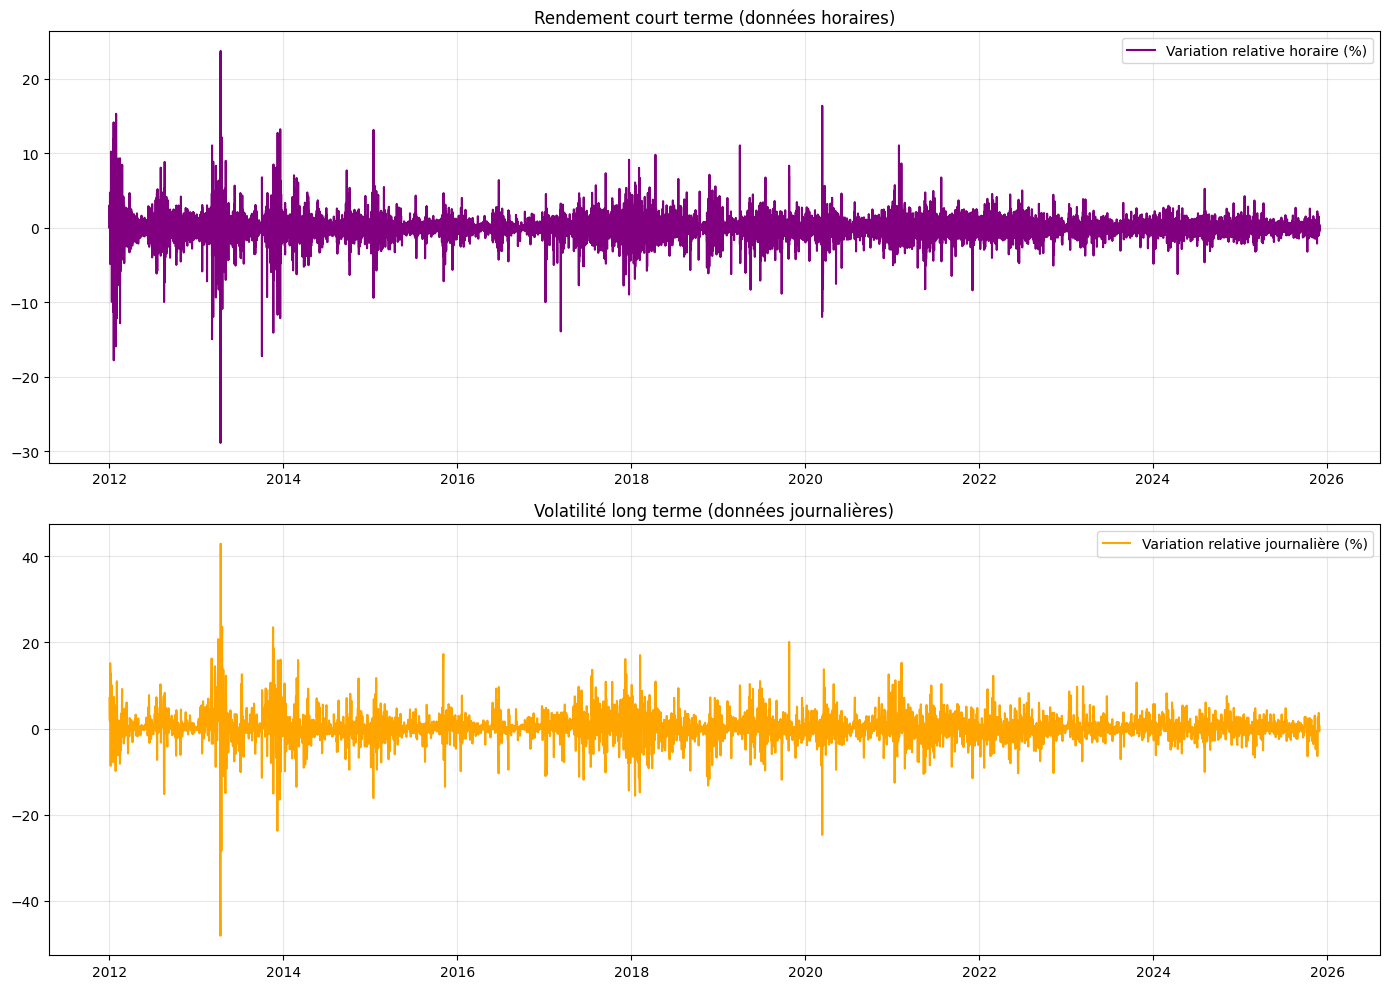

In [36]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

ax1.plot(df_bitcoin_1_hour.index, df_bitcoin_1_hour['returns'] * 100, color='purple', label='Variation relative horaire (%)')
ax1.set_title('Rendement court terme (données horaires)')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(df_bitcoin_1_day.index, df_bitcoin_1_day['returns'] * 100, color='orange', label='Variation relative journalière (%)')
ax2.set_title('Volatilité long terme (données journalières)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Relation entre prix et volume

In [37]:
df_bitcoin_1_day['returns_abs'] = df_bitcoin_1_day['returns'].abs()
correlation_movement = df_bitcoin_1_day[('Volume', 'mean')].corr(df_bitcoin_1_day['returns_abs'])

print(f"Corrélation volume-prix : {df_bitcoin_1_day[('Volume', 'mean')].corr(df_bitcoin_1_day[('Close', 'mean')]):.3f}")
print(f"Corrélation volume-mouvement : {correlation_movement:.3f}")

Corrélation volume-prix : -0.328
Corrélation volume-mouvement : 0.529


On remarque une plus forte corrélation entre le volume d'échange du Bitcoin et les mouvement de prix.

# Heatmap de corrélation entre volume d'échange et heure / jour de la semaine

In [38]:
import plotly.express as px

df_bitcoin_heatmap = df_bitcoin_raw.copy()

df_bitcoin_heatmap['hour'] = df_bitcoin_heatmap.index.hour
df_bitcoin_heatmap['day_of_week'] = df_bitcoin_heatmap.index.day_name()

days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

pivot_volume = df_bitcoin_heatmap.pivot_table(
    values='Volume',
    index='day_of_week',
    columns='hour',
    aggfunc='mean'
)

pivot_volume = pivot_volume.reindex(days_order)

fig = px.imshow(pivot_volume,
                labels=dict(x="Heure du jour", y="Jour de la semaine", color="Volume moyen d\'échange"),
                x=pivot_volume.columns,
                y=pivot_volume.index,
                aspect="auto",
                title="Volume d\'échange moyen du Bitcoin par heure et jour de la semaine")

fig.update_xaxes(side="bottom")
fig.update_layout(height=500, width=1200)
fig.show()
